In [1]:
# Cell 1: All Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Pre-processing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Models ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- Evaluation ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plot style
sns.set(style='whitegrid')
print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# Cell 2: Load and Clean Data (Updated)
print("--- Phase 1: Data Cleaning and Pre-processing ---")

# Check for the new file
file_path = 'car_web_scraped_dataset.csv'
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}.")
    print("Please make sure you have uploaded 'car_web_scraped_dataset.csv'.")
    df = None # Set df to None so other cells skip
else:
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset '{file_path}' loaded successfully.")
        print(f"Initial shape: {df.shape}")

        # Step 2: Clean Target Variable (Price)
        df['price'] = df['price'].replace({r'[\$,]': ''}, regex=True)
        df['price'] = pd.to_numeric(df['price'])
        print("Price column cleaned.")

        # Step 3: Clean Feature Columns (Miles)
        df['miles'] = df['miles'].replace({r' miles': '', ',': ''}, regex=True)
        df['miles'] = pd.to_numeric(df['miles'], errors='coerce')
        print("Miles column cleaned.")

        # Step 4: Handle Missing Values from cleaning
        # Fill any rows where 'miles' failed to convert with the median
        miles_median = df['miles'].median()
        df['miles'].fillna(miles_median, inplace=True)

        # Drop any rows that have missing 'name', 'year', 'color', or 'condition'
        # These are essential for our features, so we can't use rows without them.
        df.dropna(subset=['name', 'year', 'color', 'condition'], inplace=True)

        # Step 5: Handle Duplicates
        duplicates_found = df.duplicated().sum()
        df.drop_duplicates(inplace=True)
        print(f"Removed {duplicates_found} duplicate rows. New shape: {df.shape}")

    except Exception as e:
        print(f"Error loading or cleaning data: {e}")
        df = None



--- Phase 1: Data Cleaning and Pre-processing ---
Dataset 'car_web_scraped_dataset.csv' loaded successfully.
Initial shape: (2840, 6)
Price column cleaned.
Miles column cleaned.
Removed 528 duplicate rows. New shape: (2312, 6)


/tmp/ipython-input-3646038335.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['miles'].fillna(miles_median, inplace=True)



--- Phase 2: Exploratory Data Analysis (EDA) ---
--- Price Distribution Summary Table ---
price_range
0-10k       142
10k-20k     724
20k-30k     805
30k-40k     415
40k-50k     135
50k-75k      75
75k-100k     10
100k+         6
Name: count, dtype: int64

This table clearly shows the 'imbalance': most cars are under $30,000.

--- Managing the Imbalance (Skew) ---
To fix this, we will create a 'log_price' column.
Showing Price Distribution plot (Bar Chart and Histogram)...


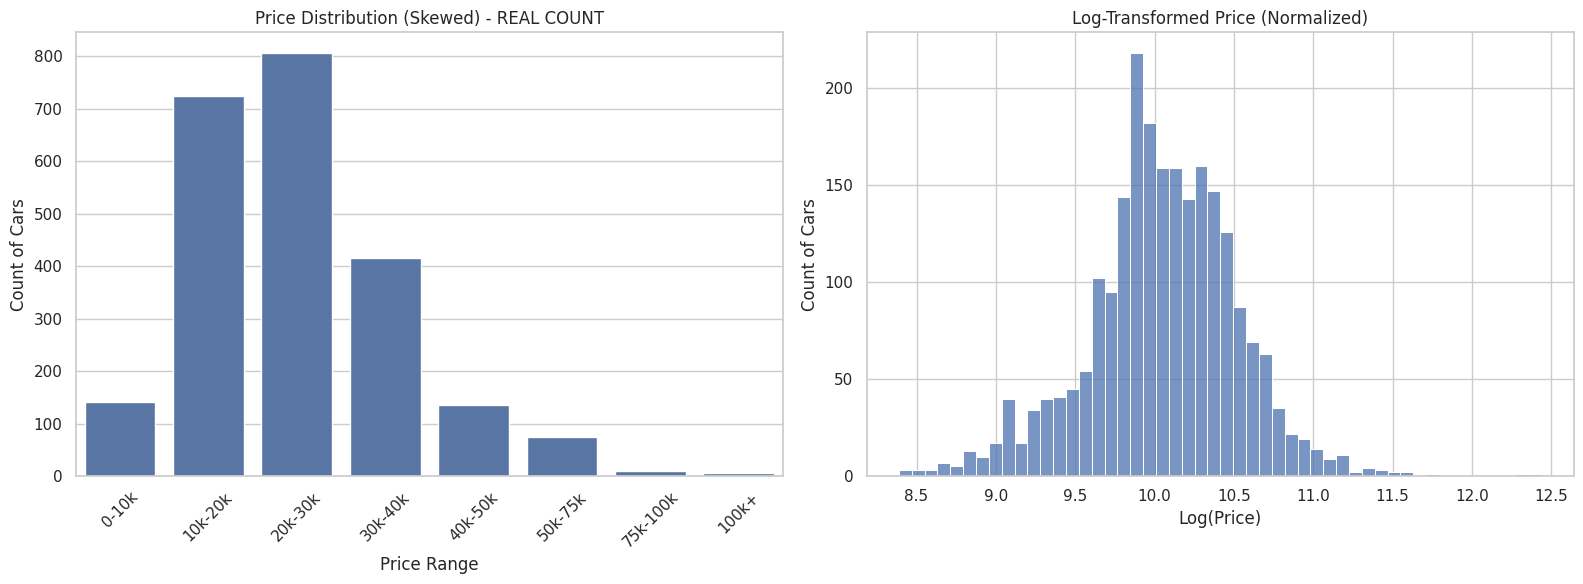


Conclusion: The table and left chart show the imbalance. The right chart shows our fix.
We will use 'log_price' as our target variable.


In [3]:
# Cell 3: Analyze Target Variable (Imbalance)
if df is not None:
    print("\n--- Phase 2: Exploratory Data Analysis (EDA) ---")

    # --- Step 1: Create a Price Range Summary Table ---
    # This proves the "imbalance" (skew) in our data.
    price_bins = [0, 10000, 20000, 30000, 40000, 50000, 75000, 100000, np.inf]
    bin_labels = ['0-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-75k', '75k-100k', '100k+']

    df['price_range'] = pd.cut(df['price'], bins=price_bins, labels=bin_labels, right=False)
    price_summary = df['price_range'].value_counts().sort_index()

    print("--- Price Distribution Summary Table ---")
    print(price_summary)
    print("\nThis table clearly shows the 'imbalance': most cars are under $30,000.")

    # --- Step 2: Create 'log_price' to manage the imbalance ---
    print("\n--- Managing the Imbalance (Skew) ---")
    print("To fix this, we will create a 'log_price' column.")
    df['log_price'] = np.log1p(df['price']) # np.log1p is log(1+x)

    # --- Step 3: Plot "Before-and-After" Graphs ---
    print("Showing Price Distribution plot (Bar Chart and Histogram)...")
    plt.figure(figsize=(16, 6))

    # Plot 1: The "Before" (Bar Chart) - This visualizes our table.
    plt.subplot(1, 2, 1)
    sns.barplot(x=price_summary.index, y=price_summary.values)
    plt.title('Price Distribution (Skewed) - REAL COUNT')
    plt.xlabel('Price Range')
    plt.ylabel('Count of Cars')
    plt.xticks(rotation=45)

    # Plot 2: The "After" (Histogram) - This shows our fix.
    plt.subplot(1, 2, 2)
    sns.histplot(df['log_price'], bins=50)
    plt.title('Log-Transformed Price (Normalized)')
    plt.xlabel('Log(Price)')
    plt.ylabel('Count of Cars')

    plt.tight_layout()
    plt.show()

    print("\nConclusion: The table and left chart show the imbalance. The right chart shows our fix.")
    print("We will use 'log_price' as our target variable.")
else:
    print("DataFrame `df` is not loaded. Skipping Cell 3.")


--- Creating New Features (Feature Engineering) ---
New features created: 'car_age', 'brand', 'ext_color', 'int_color', 'has_accidents', 'num_owners'


/tmp/ipython-input-3443310467.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ext_color'].fillna('Unknown', inplace=True)
/tmp/ipython-input-3443310467.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

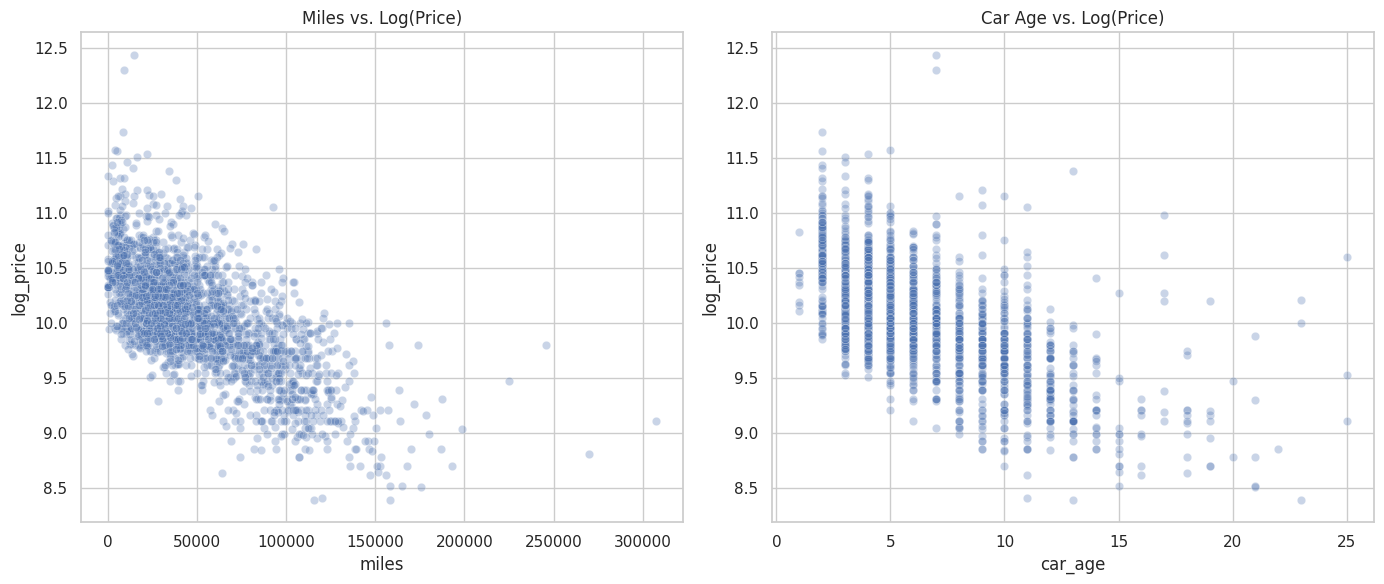

In [5]:
# Cell 4: Feature Engineering & Analysis
if df is not None:
    print("\n--- Creating New Features (Feature Engineering) ---")

    # 1. Create 'car_age' from 'year'
    current_year = 2025
    df['car_age'] = current_year - df['year']

    # 2. Create 'brand' from 'name'
    # 'Kia Forte' -> 'Kia'
    df['brand'] = df['name'].str.split(' ').str[0]

    # 3. Create 'ext_color' and 'int_color' from 'color'
    # 'Gray exterior, Black interior' -> 'Gray' and 'Black'
    df['ext_color'] = df['color'].str.split(' exterior, ').str[0]
    df['int_color'] = df['color'].str.split(' exterior, ').str[1].str.replace(' interior', '')
    # Fill in 'Unknown' for any we couldn't split
    df['ext_color'].fillna('Unknown', inplace=True)
    df['int_color'].fillna('Unknown', inplace=True)

    # 4. Create 'has_accidents' from 'condition'
    # 'No accidents reported' -> 0, '1 accident reported' -> 1
    df['has_accidents'] = (~df['condition'].str.contains('No accidents reported')).astype(int)

    # 5. Create 'num_owners' from 'condition'
    # '1 Owner' -> 1, '3 Owners' -> 3
    df['num_owners'] = df['condition'].str.extract(r'(\d+) Owner').astype(float)
    # Fill missing owners with the median (middle) value
    df['num_owners'].fillna(df['num_owners'].median(), inplace=True)

    print("New features created: 'car_age', 'brand', 'ext_color', 'int_color', 'has_accidents', 'num_owners'")

    # --- Plot our new numeric features vs. price ---
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x='miles', y='log_price', alpha=0.3)
    plt.title('Miles vs. Log(Price)')

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x='car_age', y='log_price', alpha=0.3)
    plt.title('Car Age vs. Log(Price)')

    plt.tight_layout()
    plt.show()
else:
    print("DataFrame `df` is not loaded. Skipping Cell 4.")

In [7]:
# Cell 5: Split & Pre-processing
if df is not None:
    print("\n--- Phase 3: Final Preparation & Pre-processing ---")

    # --- Step 1: Define Features (X) and Target (y) ---
    target = 'log_price'


    numeric_features = ['miles', 'car_age', 'num_owners']

    categorical_features = ['brand', 'ext_color', 'int_color', 'has_accidents']

    features = numeric_features + categorical_features

    X = df[features]
    y = df[target]

    print(f"Features selected: {features}")

    # --- Step 2: Train-Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set has {X_train.shape[0]} samples. Test set has {X_test.shape[0]} samples.")

    # --- Step 3: Build Pre-processing Pipeline ---
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # --- Step 4: Fit and Transform the Data ---
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    print(f"Data processed. New input shape (columns): {X_train_processed.shape[1]}")
else:
    print("DataFrame `df` is not loaded. Skipping Cell 5.")


--- Phase 3: Final Preparation & Pre-processing ---
Features selected: ['miles', 'car_age', 'num_owners', 'brand', 'ext_color', 'int_color', 'has_accidents']
Training set has 1849 samples. Test set has 463 samples.
Data processed. New input shape (columns): 70


In [9]:
# Cell 6: Evaluation Function
results = {} #main "Grade Book"

def evaluate_model(y_true_log, y_pred_log, model_name):
    """Converts log prices back to dollars and calculates MAE, RMSE, and R2."""

    y_true_dollar = np.expm1(y_true_log)
    y_pred_dollar = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_true_dollar, y_pred_dollar)
    rmse = np.sqrt(mean_squared_error(y_true_dollar, y_pred_dollar))
    r2 = r2_score(y_true_dollar, y_pred_dollar)

    print(f"\n--- {model_name} Results ---")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

    return {'Model': model_name, 'R2': r2, 'MAE': mae, 'RMSE': rmse}

print("Evaluation function 'evaluate_model' defined.")

Evaluation function 'evaluate_model' defined.


In [10]:
# Cell 7: Model 1 (Traditional ML - Random Forest)
if 'X_train_processed' in locals():
    print("\n--- Phase 4: Model Implementation ---")
    print("\nTraining Model 1: Random Forest (Base)...")

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_processed, y_train)
    y_pred_log_rf = rf_model.predict(X_test_processed)

    results['RF_Base'] = evaluate_model(y_test, y_pred_log_rf, "Random Forest (Base)")
else:
    print("Processed data not found. Skipping Cell 7.")


--- Phase 4: Model Implementation ---

Training Model 1: Random Forest (Base)...

--- Random Forest (Base) Results ---
R-squared (R²): 0.2817
Mean Absolute Error (MAE): $5,784.58
Root Mean Squared Error (RMSE): $13,572.32


In [11]:
# Cell 8: Model 2 (Deep Learning - Base)
if 'X_train_processed' in locals():
    print("\nTraining Model 2: Deep Learning (Base)...")

    # 1. Prepare data
    X_train_dense = X_train_processed.toarray()
    X_test_dense = X_test_processed.toarray()
    input_shape = X_train_dense.shape[1]
    print(f"Input shape for DL model: {input_shape} columns")

    # 2. Build the model blueprint
    dl_model = Sequential([
        Dense(64, activation='relu', input_shape=[input_shape]),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # 3. Compile the model
    dl_model.compile(optimizer='adam', loss='mean_squared_error')
    print(dl_model.summary())

    # 4. Train the model
    dl_model.fit(X_train_dense, y_train, epochs=50, batch_size=32, verbose=0)
    print("DL (Base) model training finished.")

    # 5. Make predictions
    y_pred_log_dl = dl_model.predict(X_test_dense).flatten()

    # 6. Grade the model
    results['DL_Base'] = evaluate_model(y_test, y_pred_log_dl, "Deep Learning (Base)")
else:
    print("Processed data not found. Skipping Cell 8.")


Training Model 2: Deep Learning (Base)...
Input shape for DL model: 70 columns


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,657 (26.00 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 0 (0.00 B)

None
DL (Base) model training finished.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- Deep Learning (Base) Results ---
R-squared (R²): 0.1747
Mean Absolute Error (MAE): $6,075.20
Root Mean Squared Error (RMSE): $14,547.95


In [12]:
# Cell 9:Model Tuning (Random Forest)
if 'X_train_processed' in locals():
    print("\n--- Phase 5: Model Tuning & Optimization ---")
    print("\nTuning Model 1: Random Forest...")

    # 1. Create a SIMPLER "menu" of settings
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None]
    }

    # 2. Set up the "Random Search" tool
    rf_random = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
        param_distributions=param_dist,
        n_iter=5,      # Try only 5 random combinations
        cv=3,
        random_state=42,
        n_jobs=-1
    )

    # 3. Start the search
    rf_random.fit(X_train_processed, y_train)
    print(f"\nBest RF Params found: {rf_random.best_params_}")

    # 4. Make predictions with the BEST model
    y_pred_log_rf_tuned = rf_random.predict(X_test_processed)

    # 5. Grade the new tuned model
    results['RF_Tuned'] = evaluate_model(y_test, y_pred_log_rf_tuned, "Random Forest (Tuned)")
else:
    print("Processed data not found. Skipping Cell 9.")


--- Phase 5: Model Tuning & Optimization ---

Tuning Model 1: Random Forest...

Best RF Params found: {'n_estimators': 300, 'max_depth': 20}

--- Random Forest (Tuned) Results ---
R-squared (R²): 0.2844
Mean Absolute Error (MAE): $5,732.58
Root Mean Squared Error (RMSE): $13,546.85


In [13]:
# Cell 10: Model Tuning (Deep Learning)
if 'X_train_processed' in locals():
    print("\nTuning Model 2: Deep Learning (Manual)...")
    print("We will build a bigger model to see if it performs better.")

    # 1. Build a BIGGER model blueprint
    dl_model_tuned = Sequential([
        Dense(128, activation='relu', input_shape=[input_shape]), # Bigger layer
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # 2. Compile
    dl_model_tuned.compile(optimizer='adam', loss='mean_squared_error')
    print(dl_model_tuned.summary())

    # 3. Train
    dl_model_tuned.fit(X_train_dense, y_train, epochs=50, batch_size=32, verbose=0)
    print("DL (Tuned) model training finished.")

    # 4. Predict
    y_pred_log_dl_tuned = dl_model_tuned.predict(X_test_dense).flatten()

    # 5. Grade
    results['DL_Tuned'] = evaluate_model(y_test, y_pred_log_dl_tuned, "Deep Learning (Tuned)")
else:
    print("Processed data not found. Skipping Cell 10.")


Tuning Model 2: Deep Learning (Manual)...
We will build a bigger model to see if it performs better.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,457 (76.00 KB)

 Trainable params: 19,457 (76.00 KB)

 Non-trainable params: 0 (0.00 B)

None
DL (Tuned) model training finished.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Deep Learning (Tuned) Results ---
R-squared (R²): 0.1289
Mean Absolute Error (MAE): $6,428.34
Root Mean Squared Error (RMSE): $14,945.58


In [14]:
# Cell 11: Final Model Comparison
if results:
    print("\n\n--- Final Model Comparison ---")

    # Convert our 'results' grade book into a pandas DataFrame (a table)
    results_df = pd.DataFrame(results.values())
    results_df.set_index('Model', inplace=True)

    # Sort the table by 'Mean Absolute Error' (MAE), best to worst
    results_df.sort_values(by='MAE', ascending=True, inplace=True)

    # Print the final, formatted table
    print(results_df.to_string(float_format="{:,.2f}".format))
else:
    print("No results to display. Please run the model cells.")



--- Final Model Comparison ---
                        R2      MAE      RMSE
Model                                        
Random Forest (Tuned) 0.28 5,732.58 13,546.85
Random Forest (Base)  0.28 5,784.58 13,572.32
Deep Learning (Base)  0.17 6,075.20 14,547.95
Deep Learning (Tuned) 0.13 6,428.34 14,945.58
